In [1]:
from data_processing import process_mat_file
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from climate_extreme import ClimateExtreme
import climate_stats as cs
import scipy.stats as stats

from BucketModel import BucketModel, BucketModelOptimizer
from BucketModel.data_processing import preprocess_for_bucket_model, run_multiple_simulations
from BucketModel.bucket_model_plotter import *

from climate_simulation import run_model_for_future_climate, plot_climate_scenarios, combine_climate_data

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

import statsmodels.tsa.api as smt
import statsmodels.api as sm


from generate_future_climate import generate_future_climate

import os

from multiprocessing import Pool, cpu_count

import warnings

warnings.filterwarnings("ignore")

## (WEEK 1) Simulating ensembles with the WeaGETS weather generator.
### Reading in the input data and the output files from WeaGETS

In [2]:
input_data_path = "/Users/cooper/Desktop/climate-impacts/data/Input_data.mat"
path_exp_first = "/Users/cooper/Desktop/climate-impacts/data/Exponential/Seperated_FirstOrder_Exp_1500(30).mat"
path_gamma_third = "/Users/cooper/Desktop/climate-impacts/data/Gamma/Seperated_ThirdOrder_Gamma_1500(30).mat"

present_data = process_mat_file(input_data_path)
exp_first_data = process_mat_file(path_exp_first)
gamma_third_data = process_mat_file(path_gamma_third)

In [3]:
present_data

,Precipitation,T_max,T_min,T_avg,Year,Month,Day
0,0.4,1.5,-10.1,-4.30,1986,Jan,1
1,5.9,4.1,-2.0,1.05,1986,Jan,2
2,0.0,4.1,-3.1,0.50,1986,Jan,3
3,7.8,-0.3,-11.7,-6.00,1986,Jan,4
4,0.0,1.4,-10.1,-4.35,1986,Jan,5
...,...,...,...,...,...,...,...
12405,13.7,3.4,-1.1,1.15,2019,Dec,27
12406,0.4,2.2,-3.6,-0.70,2019,Dec,28
12407,0.0,5.7,-3.2,1.25,2019,Dec,29
12408,0.0,7.8,1.1,4.45,2019,Dec,30


In [4]:
exp_first_data

,Precipitation,T_max,T_min,T_avg,Year,Month,Day,Simulation
0,1.052159,0.575836,-3.966348,-1.695256,1980,Jan,1,1
1,2.840043,2.131566,-2.196253,-0.032343,1980,Jan,2,1
2,0.000000,0.337740,-2.734396,-1.198328,1980,Jan,3,1
3,0.000000,4.614041,0.185355,2.399698,1980,Jan,4,1
4,2.044771,2.277004,-3.072299,-0.397647,1980,Jan,5,1
...,...,...,...,...,...,...,...,...
547495,13.138856,-2.289081,-9.061114,-5.675098,2009,Dec,27,50
547496,7.726682,-2.705927,-8.001282,-5.353604,2009,Dec,28,50
547497,5.920434,-0.570781,-7.474422,-4.022602,2009,Dec,29,50
547498,0.000000,1.047279,-5.964266,-2.458494,2009,Dec,30,50


## Looking at climate statistics to compare generated data to observed data
### Comparing number of wet days (Precipitation > 0.1 mm) in the generated data to the observed data

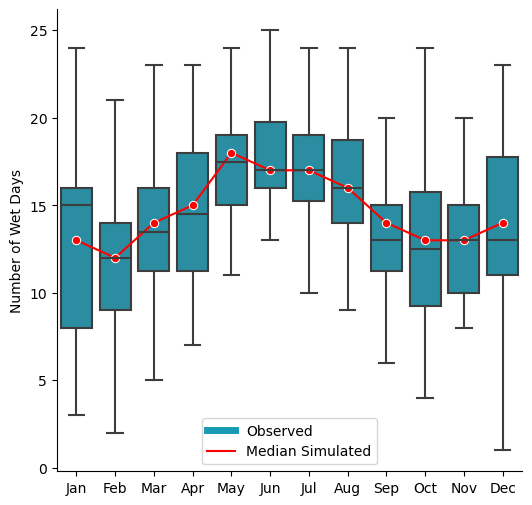

In [5]:
cs.plot_wet_days(
    present_data,
    exp_first_data,
    "/Users/cooper/Desktop/climate-impacts/images/wet_days.png",
)

### Comparing the Estimated Cumulative Distribution Function (ECDF) of the two datasets for Precipitation

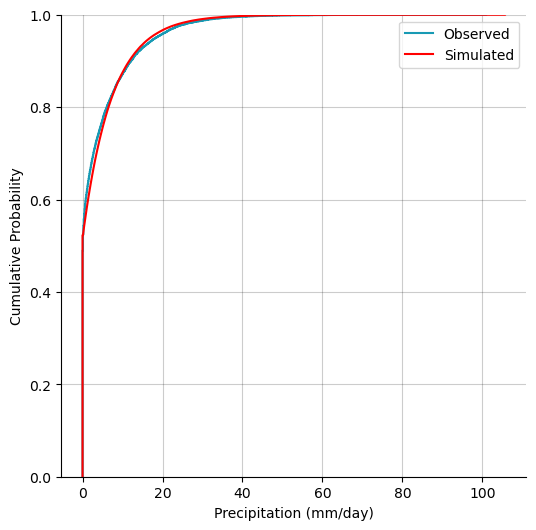

In [6]:
cs.plot_ECDF(
    observations=present_data,
    simulation=exp_first_data,
    column="Precipitation",
    xlabel="Precipitation (mm/day)",
    output_destination="/Users/cooper/Desktop/climate-impacts/images/precipitation_ecdf.png",
)

### Comparing mean and standard deviation of Average Temperature values

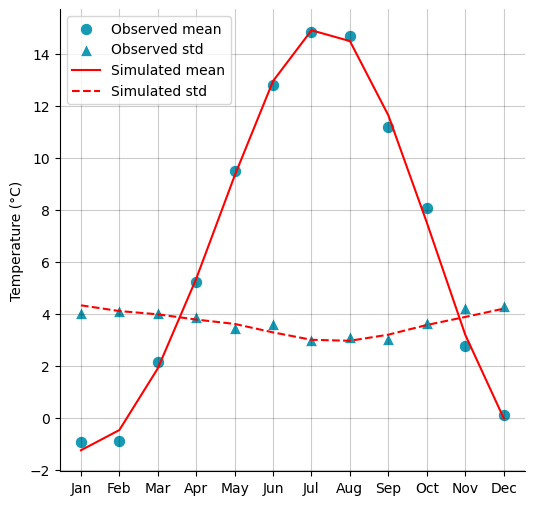

In [7]:
cs.plot_mean_and_std(observations=present_data, simulation=exp_first_data, output_destination="/Users/cooper/Desktop/climate-impacts/images/mean_std.png")

### Fit an extreme parameter distribution to the generated data and to the observed data and compare the confidence intervals of the parameters

In [8]:
observed = ClimateExtreme(present_data)
generated = ClimateExtreme(exp_first_data)
gamma_third = ClimateExtreme(gamma_third_data)


In [9]:
c, loc, scale, ci_lower, ci_upper = observed.fit_genextreme(
    "Precipitation", quantile=0.99, n_bootstrap=400
)

print(f"GEV parameters: c={c:.4f}, loc={loc:.4f}, scale={scale:.4f}")
print("Confidence Intervals:")
print(f"c: ({ci_lower[0]:.4f}, {ci_upper[0]:.4f})")
print(f"loc: ({ci_lower[1]:.4f}, {ci_upper[1]:.4f})")
print(f"scale: ({ci_lower[2]:.4f}, {ci_upper[2]:.4f})")

GEV parameters: c=-0.5578, loc=36.0812, scale=4.4721
Confidence Intervals:
c: (-0.7649, -0.3327)
loc: (35.0339, 37.3626)
scale: (3.5779, 5.4954)


In [10]:
c, loc, scale, ci_lower, ci_upper = generated.fit_genextreme(
    "Precipitation", quantile=0.99, n_bootstrap=400
)

print(f"GEV parameters: c={c:.4f}, loc={loc:.4f}, scale={scale:.4f}")
print("Confidence Intervals:")
print(f"c: ({ci_lower[0]:.4f}, {ci_upper[0]:.4f})")
print(f"loc: ({ci_lower[1]:.4f}, {ci_upper[1]:.4f})")
print(f"scale: ({ci_lower[2]:.4f}, {ci_upper[2]:.4f})")

GEV parameters: c=-0.5042, loc=33.0297, scale=3.6656
Confidence Intervals:
c: (-0.5323, -0.4750)
loc: (32.8953, 33.1845)
scale: (3.5495, 3.7933)


In [11]:
c, loc, scale, ci_lower, ci_upper = gamma_third.fit_genextreme(
    "Precipitation", quantile=0.99, n_bootstrap=400
)

print(f"GEV parameters: c={c:.4f}, loc={loc:.4f}, scale={scale:.4f}")
print("Confidence Intervals:")
print(f"c: ({ci_lower[0]:.4f}, {ci_upper[0]:.4f})")
print(f"loc: ({ci_lower[1]:.4f}, {ci_upper[1]:.4f})")
print(f"scale: ({ci_lower[2]:.4f}, {ci_upper[2]:.4f})")

GEV parameters: c=-0.4940, loc=37.2505, scale=4.4612
Confidence Intervals:
c: (-0.5270, -0.4625)
loc: (37.0818, 37.4348)
scale: (4.3215, 4.6099)


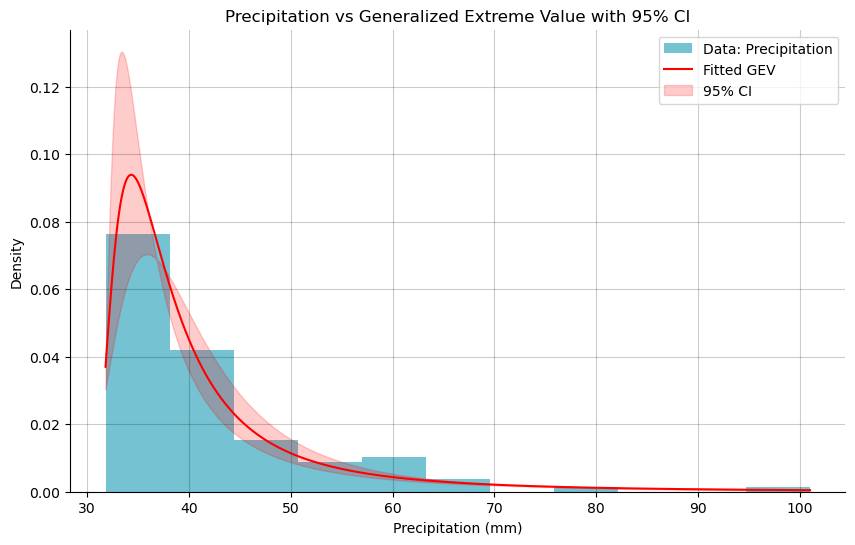

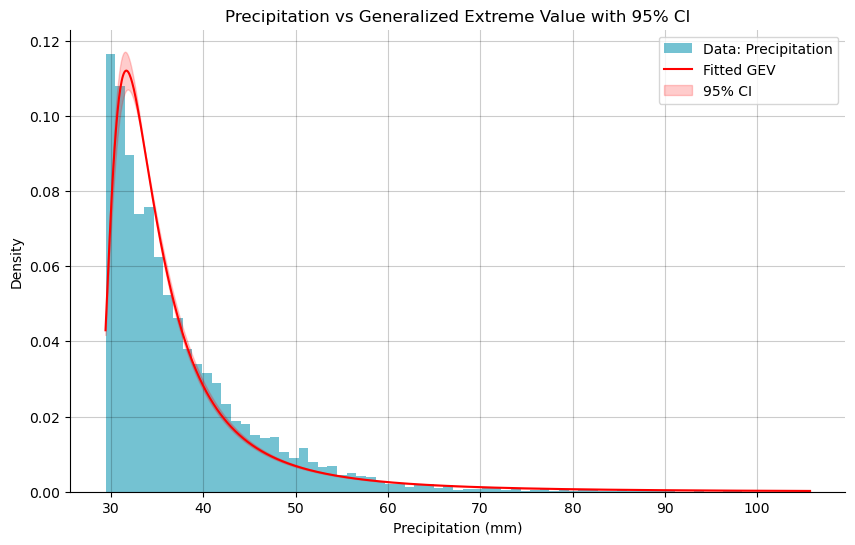

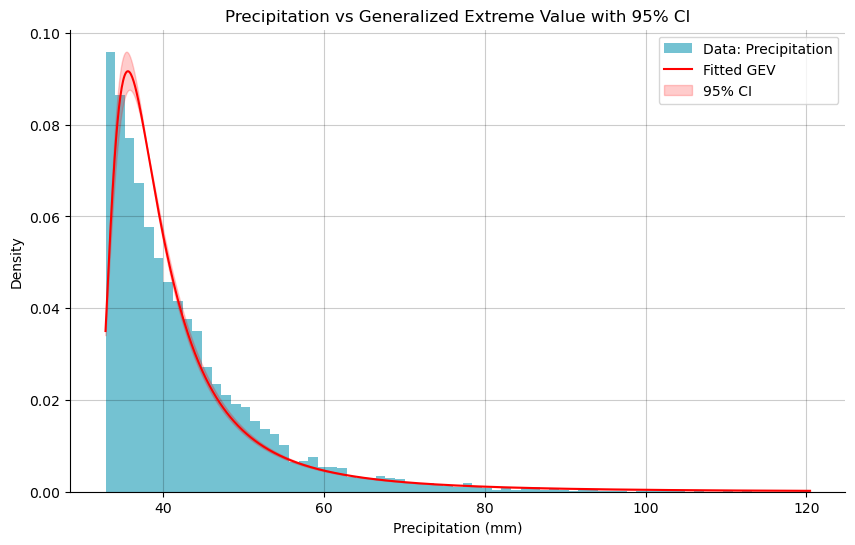

In [12]:
observed.plot_fit_and_ci("Precipitation", "mm", output_destination="/Users/cooper/Desktop/climate-impacts/images/extreme_observed_fit.png")
generated.plot_fit_and_ci("Precipitation", "mm")
gamma_third.plot_fit_and_ci("Precipitation", "mm")


#### Compare confidence intervals

In [13]:
comparison = observed.compare_ci("Precipitation", gamma_third, "Observed", "GammaThirdOrder")
comparison

,Observed_value,Observed_CI_lower,Observed_CI_upper,GammaThirdOrder_value,GammaThirdOrder_CI_lower,GammaThirdOrder_CI_upper
c,-0.557837,-0.764851,-0.332688,-0.494022,-0.526950,-0.462504
loc,36.081203,35.033857,37.362638,37.250468,37.081779,37.434794
scale,4.472108,3.577912,5.495447,4.461194,4.321484,4.609881


#### Check if confidence intervals overlap

In [14]:
overlap = all(
    comparison["Observed_CI_upper"] >= comparison["GammaThirdOrder_CI_lower"]
) and all(comparison["GammaThirdOrder_CI_upper"] >= comparison["Observed_CI_lower"])

print(f"Confidence intervals {'overlap' if overlap else 'do not overlap'}")

Confidence intervals overlap


#### Plot the distribution for visual comparison too

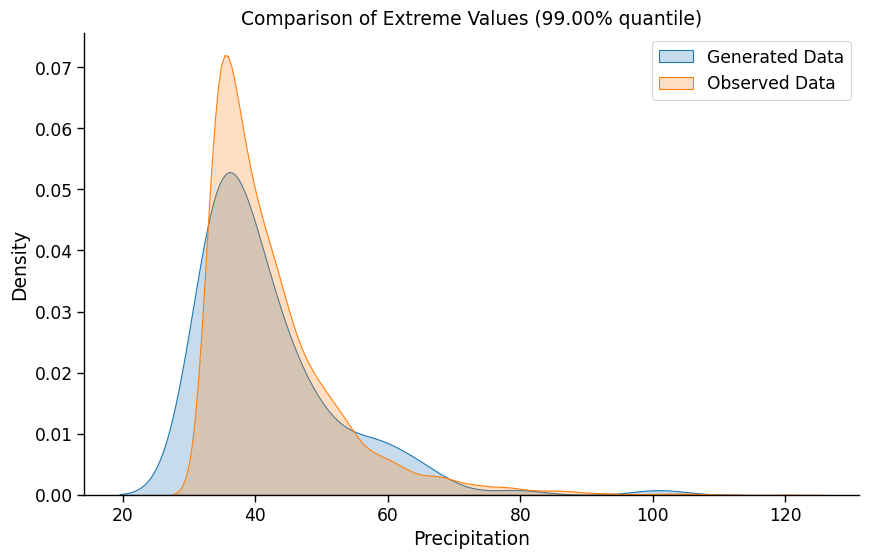

In [15]:
observed.plot_extreme_comparison("Precipitation", gamma_third, quantile=0.99)

### Perform a Truncated 2 sample KS test

In [16]:
ks_stat, p_value = observed.truncated_ks_test("Precipitation", gamma_third, quantile=0.99)
print(f"KS statistic: {ks_stat:.4f}, p-value: {p_value:.4f}")

KS statistic: 0.1240, p-value: 0.0427


### Running the Bucket Model
#### Preprocessing the data to match the format required by the Bucket Model


In [17]:
processed_present_data = preprocess_for_bucket_model(present_data)
processed_exp_first_data = preprocess_for_bucket_model(exp_first_data)
processed_gamma_third_data = preprocess_for_bucket_model(gamma_third_data)

In [18]:
processed_present_data

,P_mix,T_max,T_min
date,,,
1986-01-01,0.4,1.5,-10.1
1986-01-02,5.9,4.1,-2.0
1986-01-03,0.0,4.1,-3.1
1986-01-04,7.8,-0.3,-11.7
1986-01-05,0.0,1.4,-10.1
...,...,...,...
2019-12-27,13.7,3.4,-1.1
2019-12-28,0.4,2.2,-3.6
2019-12-29,0.0,5.7,-3.2


In [19]:
processed_exp_first_data

,P_mix,T_max,T_min,Simulation
date,,,,
1980-01-01,1.052159,0.575836,-3.966348,1
1980-01-02,2.840043,2.131566,-2.196253,1
1980-01-03,0.000000,0.337740,-2.734396,1
1980-01-04,0.000000,4.614041,0.185355,1
1980-01-05,2.044771,2.277004,-3.072299,1
...,...,...,...,...
2009-12-27,13.138856,-2.289081,-9.061114,50
2009-12-28,7.726682,-2.705927,-8.001282,50
2009-12-29,5.920434,-0.570781,-7.474422,50


### Setting up the model for the catchment of Gsteig and the calibrated parameters from Assignment 2

In [20]:
bucket_model = BucketModel(
    k=0.83, S_max=12.554, fr=0.111, rg=23.587, gauge_adj=0.267
)  # Parameters from Assignment 2

bucket_model.set_catchment_properties(
    lapse_rate=0.5 / 100,  # °C/m
    station_elevation=1638,  # m.a.s.l
    basin_elevation=2035,  # m.a.s.l
    snowmelt_temp_threshold=0,  # °C
    latitude=46.9, # °N
) 

#### Running the model for the present data and visualising the results

In [21]:
results = bucket_model.run(data=processed_present_data)

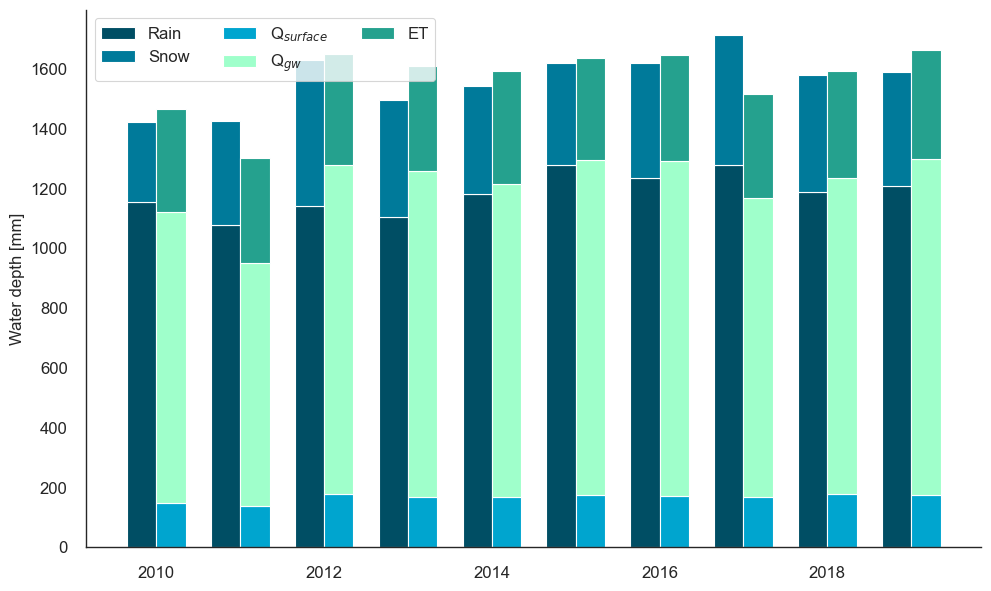

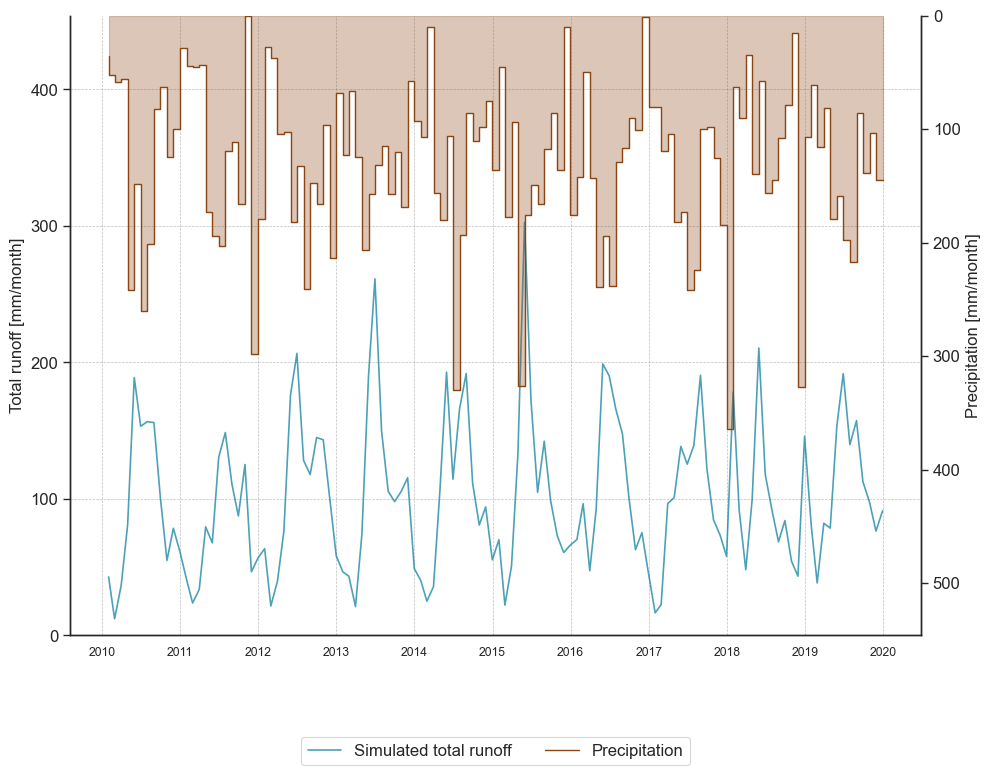

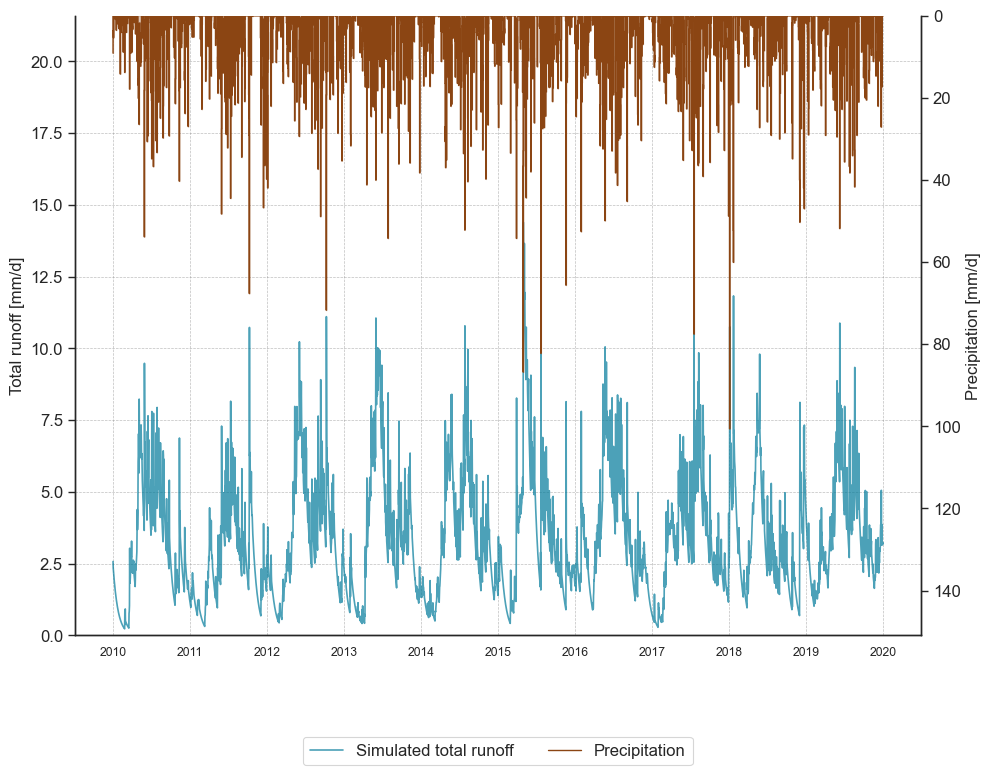

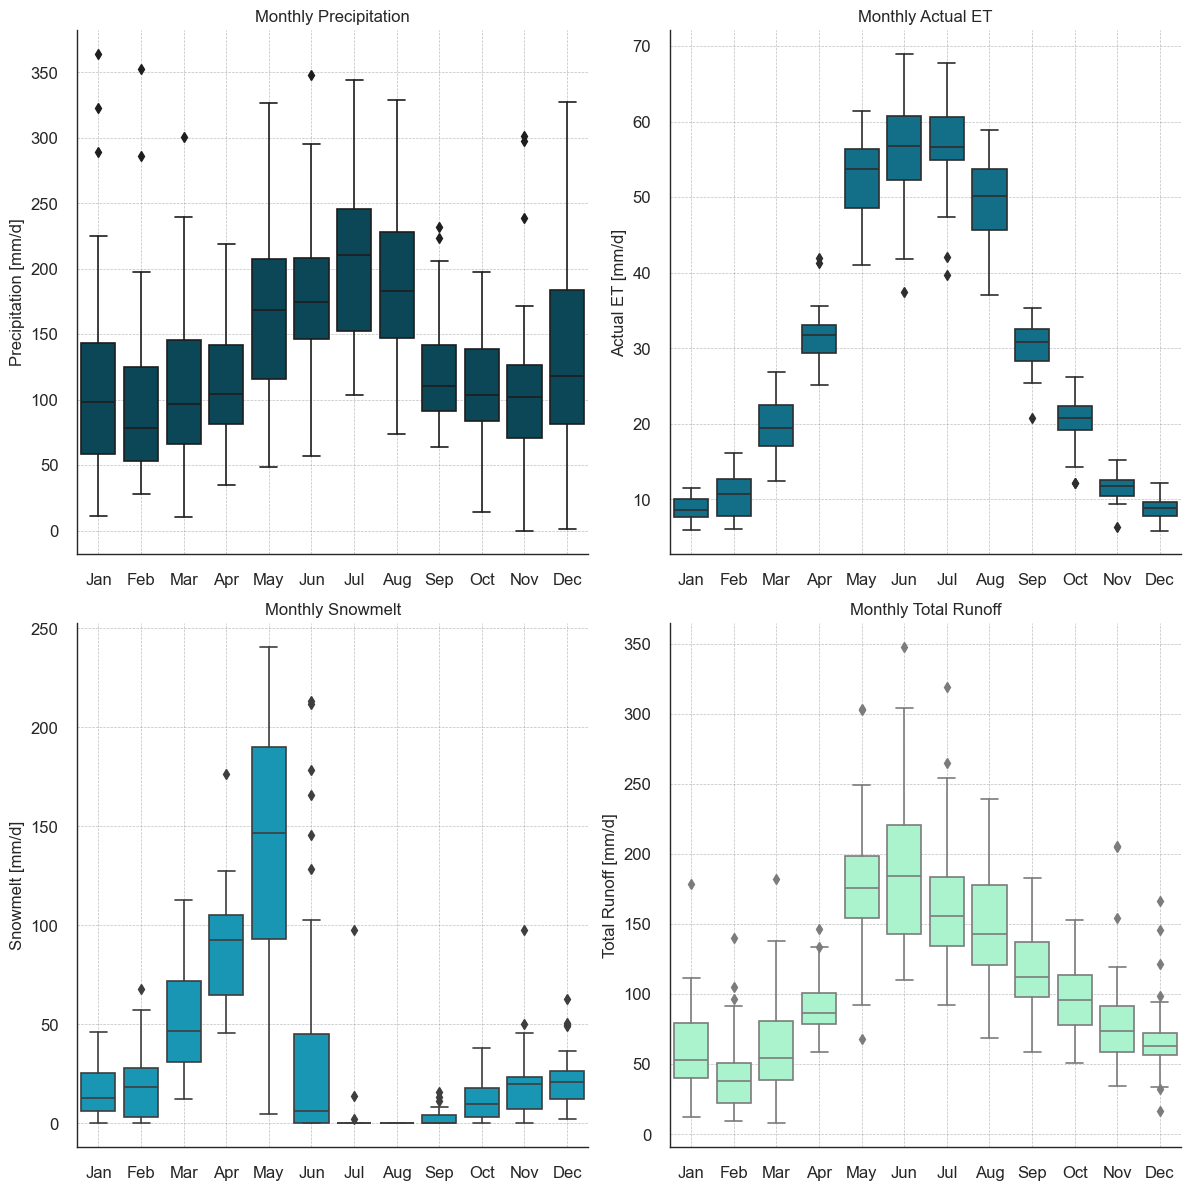

In [22]:
plot_water_balance(results=results, start_year="2010", end_year="2019")
plot_timeseries(
    results=results,
    start_year="2010",
    end_year="2019",
    monthly=True,
    plot_precipitation=True,
)
plot_timeseries(
    results=results,
    start_year="2010",
    end_year="2019",
    monthly=False,
    plot_precipitation=True,
)
plot_monthly_boxplot(results=results)

### Example of how to run the model for each Simulation individually

In [23]:
multiple_results = run_multiple_simulations(
    preprocessed_simulated_data=processed_gamma_third_data,
    bucket_model=bucket_model,
    n_simulations=50,
)

multiple_results_exp = run_multiple_simulations(
    preprocessed_simulated_data=processed_exp_first_data,
    bucket_model=bucket_model,
    n_simulations=50,
)

,Simulation,year,ET,Q_s,Q_gw,Snow_accum,S,S_gw,Snow_melt,Rain,Snow,Precip,total_runoff
month,,,,,,,,,,,,,
1,25.5,1994.5,8.571103,4.994826,44.532357,4299.541116,349.658321,1039.860110,18.115919,28.980829,86.561979,115.542808,49.527184
2,25.5,1994.5,10.322189,4.656432,31.520673,5465.455902,306.070569,742.204476,20.304998,24.853945,69.160754,94.014699,36.177106
3,25.5,1994.5,18.998563,9.524344,44.080773,7314.200420,352.192681,1056.754219,44.967447,45.501323,69.327486,114.828809,53.605117
4,25.5,1994.5,32.217447,18.556524,77.885928,6713.467139,363.613884,1878.167480,93.855621,76.391882,39.899163,116.291045,96.442452
5,25.5,1994.5,51.531789,32.032977,150.801472,3909.912051,372.763025,3614.624864,139.462681,151.898954,13.505888,165.404842,182.834449
6,25.5,1994.5,59.361607,25.389812,176.886310,694.952885,310.309471,4151.296321,61.443476,176.755115,1.152331,177.907445,202.276122
7,25.5,1994.5,58.605096,21.985835,148.021496,15.583880,287.060766,3473.951672,3.036252,208.255390,0.091784,208.347174,170.007331
8,25.5,1994.5,50.069355,19.071334,128.868541,0.416745,301.026107,3024.437432,0.137481,183.241409,0.143622,183.385030,147.939875
9,25.5,1994.5,32.502318,13.907567,104.145428,4.446013,294.176527,2438.592392,1.282260,131.608349,1.785615,133.393964,118.052995


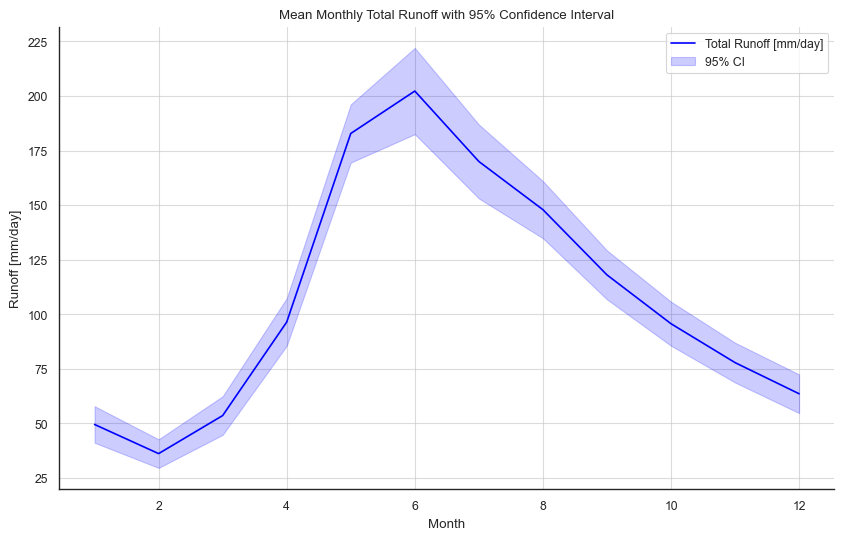

In [24]:
monthly_mean, ci = group_by_month_with_ci(multiple_results)

plot_monthly_runoff_with_ci(monthly_mean, ci)

monthly_mean

,Simulation,year,ET,Q_s,Q_gw,Snow_accum,S,S_gw,Snow_melt,Rain,Snow,Precip,total_runoff
month,,,,,,,,,,,,,
1,25.5,1994.5,8.631881,5.111693,45.510531,4436.635397,350.231959,1062.837970,18.969044,29.231988,85.279803,114.511792,50.622224
2,25.5,1994.5,10.470242,4.840433,32.922102,5515.234558,308.233566,775.057357,21.274819,25.460926,68.216845,93.677771,37.762535
3,25.5,1994.5,19.051700,9.377993,44.209137,7352.912005,353.593562,1058.398192,44.906823,44.051097,70.327776,114.378873,53.587131
4,25.5,1994.5,32.127795,18.658442,77.543993,6801.956634,364.173880,1871.172760,93.784256,77.234528,41.110616,118.345144,96.202435
5,25.5,1994.5,52.073804,33.041081,154.773231,3922.208450,374.683548,3711.676766,144.136741,156.061422,13.829394,169.890817,187.814312
6,25.5,1994.5,59.837330,24.941279,177.252621,687.215639,312.676740,4154.954001,60.478797,173.457313,1.175437,174.632750,202.193900
7,25.5,1994.5,60.192016,21.631635,145.615611,17.636829,293.514532,3414.671854,2.981407,204.592235,0.064688,204.656924,167.247246
8,25.5,1994.5,50.878858,18.990540,125.871619,0.127458,302.759451,2954.671546,0.060920,181.659672,0.081776,181.741448,144.862159
9,25.5,1994.5,32.794419,13.968930,102.150647,3.794903,300.471509,2392.847296,1.322470,131.728831,1.733968,133.462799,116.119577


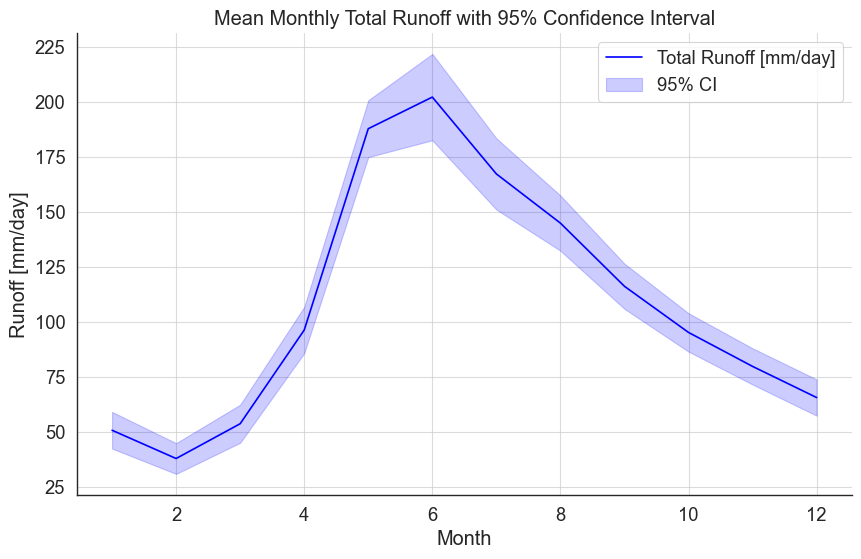

In [32]:
monthly_mean_exp, ci_exp = group_by_month_with_ci(multiple_results_exp)

plot_monthly_runoff_with_ci(monthly_mean_exp, ci_exp)

monthly_mean_exp

## (Week 2) Assessing the changes to streamflow in a future climate
### Generating future climate ensembles based on delta change method

In [26]:
# generate_future_climate(
#     data=exp_first_data,
#     name="exp_first",
#     output_folder="/Users/cooper/Desktop/climate-impacts/data/FutureExponentialTest",
# )

generate_future_climate(
    data=gamma_third_data,
    name="gamma_third",
    output_folder="/Users/cooper/Desktop/climate-impacts/data/FutureGammaTest",
)

Generating future climate data. Be patient...
Future climate data for CLMCOM-CCLM4-ECEARTH RCP4.5 saved to /Users/cooper/Desktop/climate-impacts/data/FutureGammaTest/gamma_third_CLMCOM-CCLM4-ECEARTH_RCP4.5.csv
Future climate data for CLMCOM-CCLM4-ECEARTH RCP8.5 saved to /Users/cooper/Desktop/climate-impacts/data/FutureGammaTest/gamma_third_CLMCOM-CCLM4-ECEARTH_RCP8.5.csv
Future climate data for CLMCOM-CCLM4-HADGEM RCP4.5 saved to /Users/cooper/Desktop/climate-impacts/data/FutureGammaTest/gamma_third_CLMCOM-CCLM4-HADGEM_RCP4.5.csv
Future climate data for CLMCOM-CCLM4-HADGEM RCP8.5 saved to /Users/cooper/Desktop/climate-impacts/data/FutureGammaTest/gamma_third_CLMCOM-CCLM4-HADGEM_RCP8.5.csv
Future climate data for DMI-HIRHAM-ECEARTH RCP4.5 saved to /Users/cooper/Desktop/climate-impacts/data/FutureGammaTest/gamma_third_DMI-HIRHAM-ECEARTH_RCP4.5.csv
Future climate data for DMI-HIRHAM-ECEARTH RCP8.5 saved to /Users/cooper/Desktop/climate-impacts/data/FutureGammaTest/gamma_third_DMI-HIRHAM-E

### Simulate future streamflow using the future climate ensemble and the Bucket

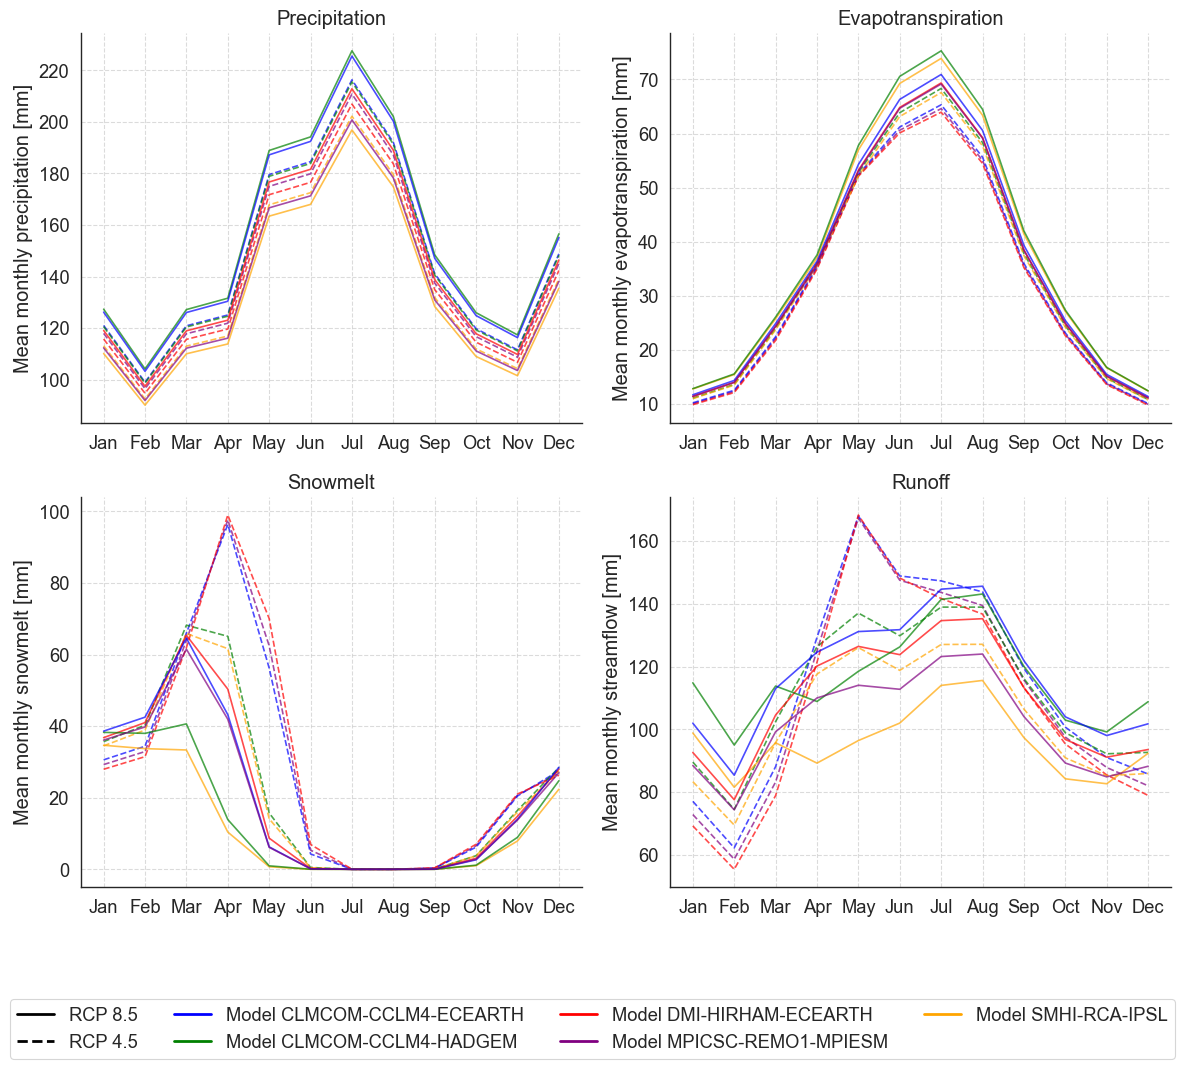

In [27]:
future_data_folder = "/Users/cooper/Desktop/climate-impacts/data/FutureExponentialTest"
results = run_model_for_future_climate(
    future_data_folder=future_data_folder,
    bucket_model=bucket_model,
)

plot_climate_scenarios(results)

### Partition uncertainty

In [28]:
from uncertainty_analysis import UncertaintyAnalysis

In [29]:
folder_path = "/Users/cooper/Desktop/climate-impacts/data/FutureExponentialTest"
combined_df = combine_climate_data(folder_path, bucket_model, 50)

In [30]:
uncertainty = UncertaintyAnalysis(combined_df)

tu = uncertainty.calculate_tu('Streamflow')
eu, eu_partition = uncertainty.calculate_eu('Streamflow', tu)
cmu, cmu_partition = uncertainty.calculate_cmu('Streamflow', tu)
su, su_partition = uncertainty.calculate_su('Streamflow', tu)

print(f"Total Uncertainty: {tu}")
print(f"Emission Scenario Uncertainty: {eu} (Partition: {eu_partition})")
print(f"Climate Model Uncertainty: {cmu} (Partition: {cmu_partition})")
print(f"Stochastic Uncertainty: {su} (Partition: {su_partition})")

Total Uncertainty: 273.66
Emission Scenario Uncertainty: 4.98 (Partition: 0.02)
Climate Model Uncertainty: 191.05 (Partition: 0.7)
Stochastic Uncertainty: 102.65 (Partition: 0.38)
